# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Rozwiązanie

In [3]:
%matplotlib notebook
import math
import random

## Kolejne zestawy punktów

### a) zawierający 100 losowo wygenerowanych punktów o współrzędnych z przedziału [-100, 100]

In [5]:
points_a = [[random.random() * 200 - 100, random.random() * 200 - 100] for _ in range(100)]
points_a[:5]

[[21.811411381813812, 55.78069118493741],
 [26.17079080265046, 55.060198158273835],
 [23.38782397199654, 97.43460014571232],
 [-44.35815014936302, 74.66162376313179],
 [24.323763818311022, 14.65633186286712]]

<IPython.core.display.Javascript object>


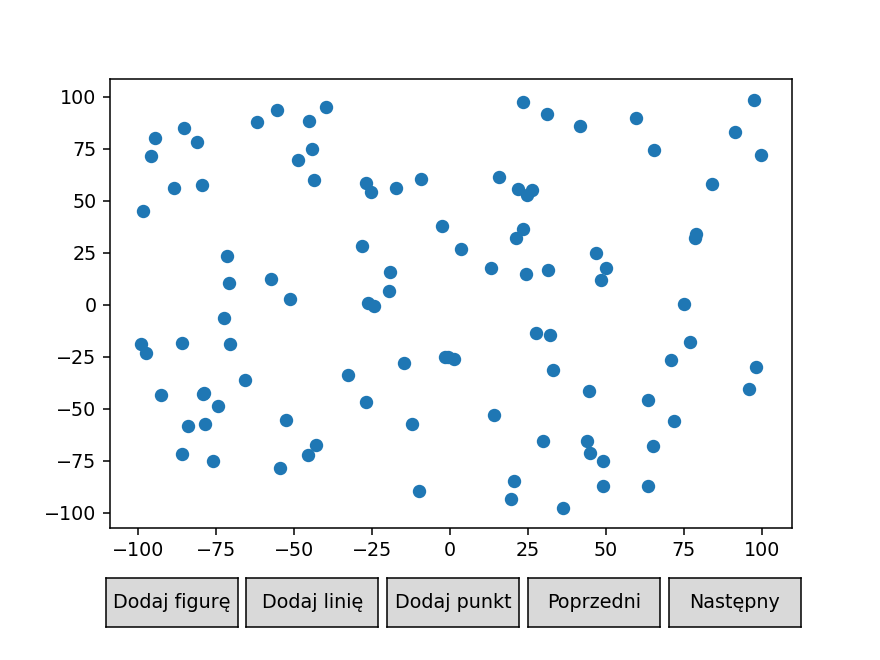

In [6]:
plot_a = Plot(points=[PointsCollection(points_a)])
plot_a.draw()

### b) zawierający 100 losowo wygenerowanych punktów leżących na okręgu o środku (0,0) i promieniu R=10

In [7]:
R = 10
points_b = []
for i in range(100):
    rand = random.random()
    points_b.append([np.cos(2*np.pi * rand) * R, np.sin(2*np.pi * rand) * R])
    
points_b[:5]

[[3.3506990092836313, 9.421932718353792],
 [3.837216522899603, 9.23448803975544],
 [9.965124902681628, 0.834437339741249],
 [-8.745316868864442, 4.849683790017142],
 [5.289881776462866, -8.486291934116224]]

<IPython.core.display.Javascript object>


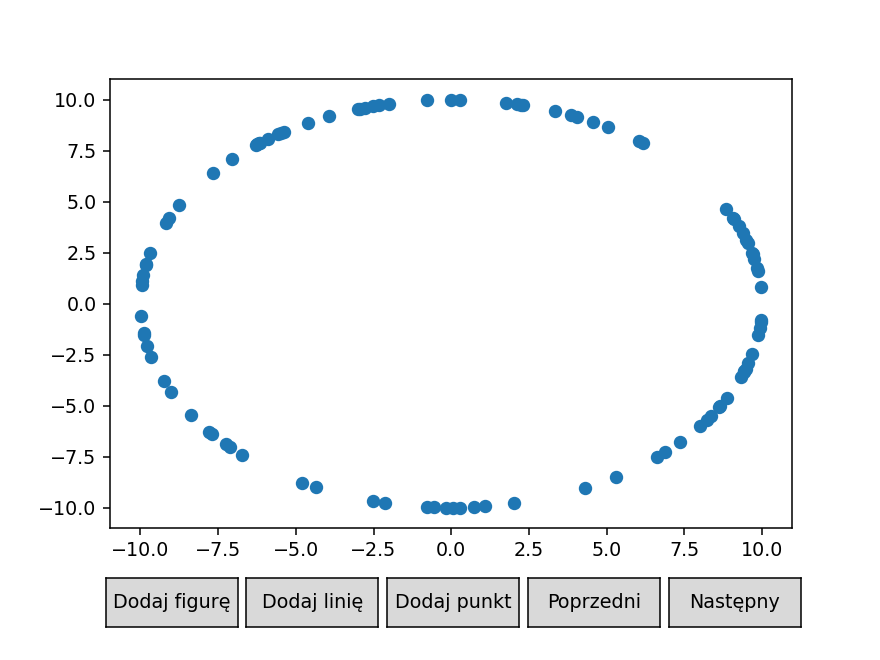

In [8]:
plot_b = Plot(points=[PointsCollection(points_b)])
plot_b.draw()

### c) zawierający 100 losowo wygenerowanych punktów leżących na bokach prostokąta o wierzchołkach (-10, 10), (-10,-10), (10,-10), (10,10)

In [9]:
points_c = []

for _ in range(100):
    rand1 = random.random() * 20 - 10
    rand2 = random.random() * 20 - 10
    if rand1 < -5:
        point = [10, rand2]
    elif rand1 < 0:
        point = [rand2, -10]
    elif rand1 < 5:
        point = [-10, rand2]
    else:
        point = [rand2, 10]
    points_c.append(point)

points_c[:5]

[[2.203801240476462, -10],
 [10, 3.089601064758426],
 [7.126761909728781, 10],
 [8.162309451285843, -10],
 [3.103219155517916, -10]]

<IPython.core.display.Javascript object>


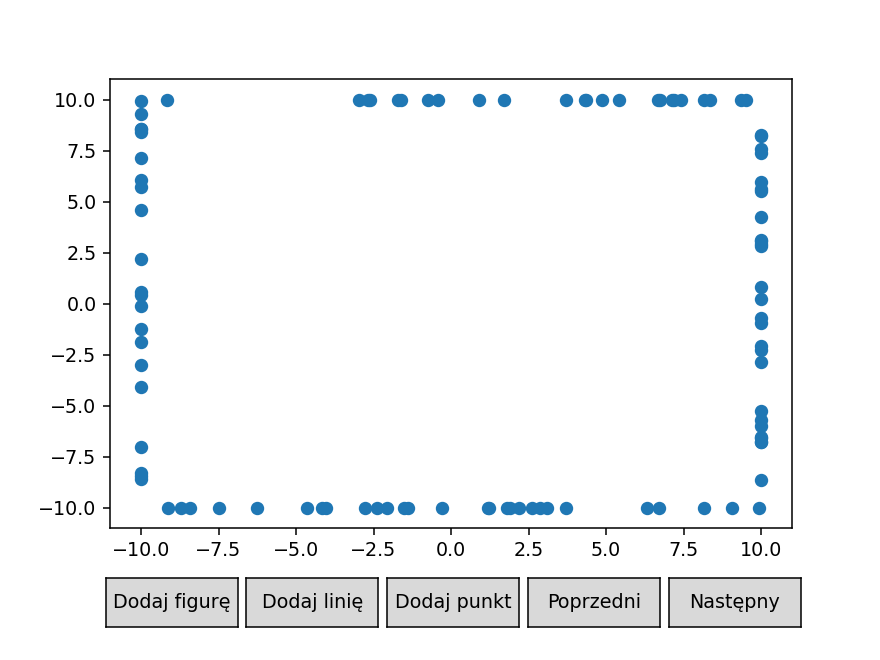

In [10]:
plot_c = Plot(points=[PointsCollection(points_c)])
plot_c.draw()

### d) zawierający wierzchołki kwadratu (0, 0), (10, 0), (10, 10), (0, 10) oraz punkty wygenerowane losowo w sposób następujący: po 25 punktów na dwóch bokach kwadratu leżących na osiach i po 20 punktów na przekątnych kwadratu.

In [11]:
points_d = [[0,0], [10,0], [10,10], [0,10]]

for i in range(25):
    rand1 = random.random() * 10
    rand2 = random.random() * 10
    points_d.append([rand1, 0])
    points_d.append([0, rand2])
    
for i in range(20):
    rand1 = random.random() * 10
    rand2 = random.random() * 10
    points_d.append([rand1, 10 - rand1])
    points_d.append([rand2, rand2])

<IPython.core.display.Javascript object>


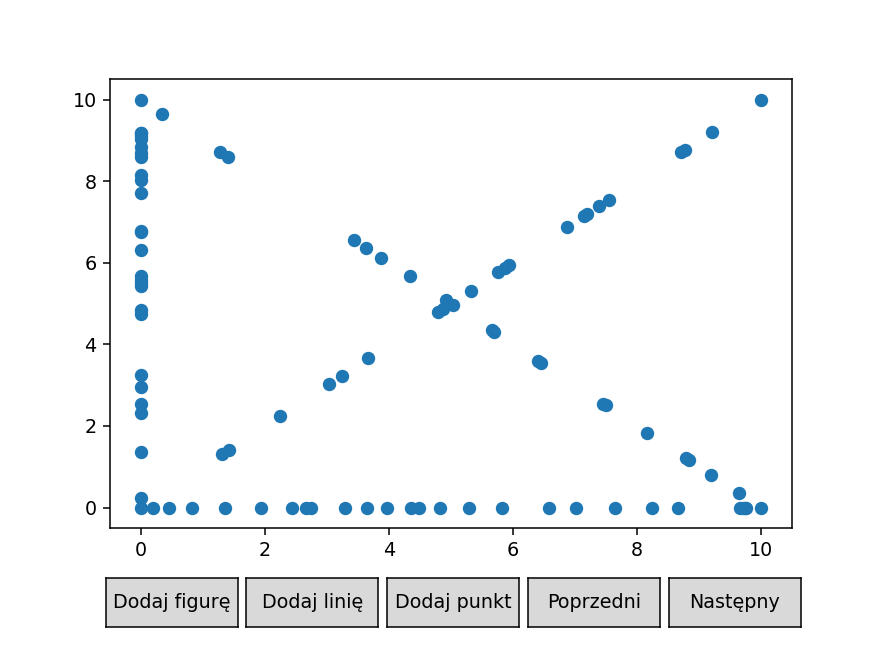

In [12]:
plot_d = Plot(points=[PointsCollection(points_d)])
plot_d.draw()

### Funkcje pozwalające na dawanie własnych parametrów przy generowaniu punktów

#### a) liczba punktów, przedziały dla współrzędnych

In [13]:
def params_a(num, start, end):
    points_a = [[random.random() * (end - start) + start, random.random() * (end - start) + start] for _ in range(num)] 
    return points_a

#### b) liczba punktów, środek i promień okręgu

In [14]:
def params_b(num, centerX, centerY, R):
    points_b = []
    for i in range(num):
        rand = random.random()
        points_b.append([np.cos(2*np.pi * rand) * R + centerX, np.sin(2*np.pi * rand) * R + centerY])

    return points_b

#### c) liczba punktów, wierzchołki prostokąta

In [15]:
def params_c(num, vertices):
    points_c = []
    min_x, min_y, max_x, max_y = float("inf"), float("inf"), -float("inf"), -float("inf")
    for v in vertices:
        min_x = min(min_x, v[0])
        max_x = max(max_x, v[0])
        min_y = min(min_x, v[1])
        max_y = max(max_x, v[1])
        
    
    height = max_x - min_x
    width = max_y - min_y

    ranges = [0, height, height + width, 2 * height + width]
        
    for _ in range(num):
        point = np.random.uniform(0, 2 * width + 2 * height)

        # right side
        if ranges[0] <= point <= ranges[1]:
            result = (max_x, min_y + point)

        # bottom side
        elif ranges[1] < point <= ranges[2]:
            result = (min_x + point - ranges[1], min_y)

        # left side
        elif ranges[2] < point <= ranges[3]:
            result = (min_x, min_y + point - ranges[2])

        # upper side
        else:
            result = (min_x + point - ranges[3], max_y)
        points_c.append(result)
    return points_c

#### d) wierzchołki kwadratu, liczba punktów na osiach, liczba punktów na przekątnych.

In [16]:
def params_d(vertices, num_on_sides, num_on_diagonal):
    points_d = []
    for v in vertices:
        points_d.append(v)
        
    min_ = 0
    max_ = -float("inf")
    for v in vertices:
        max_ = max(max_, v[0])
        
    side = max_ - min_

    for i in range(num_on_sides):
        rand1 = random.random() * side
        rand2 = random.random() * side
        points_d.append([rand1, 0])
        points_d.append([0, rand2])

    for i in range(num_on_diagonal):
        rand1 = random.random() * side
        rand2 = random.random() * side
        points_d.append([rand1, side - rand1])
        points_d.append([rand2, rand2])
    
    return points_d

### Zaimplementuj algorytmy Grahama oraz Jarvisa wyznaczające otoczkę wypukłą dla zadanego zbioru punktów. Przetestuj program na zbiorach z punktu 1 oraz zmodyfikowanych zbiorach z punktu 3.

### TOLERANCJE PRZYJMUJEMY NA 10^-12

In [17]:
TOLERANCE = 1e-12

### Funkcje pomocnicze

In [18]:
def my_det_3x3(a):
    return a[0][0] * (a[1][1] * a[2][2] - a[2][1] * a[1][2])\
           -a[1][0] * (a[0][1] * a[2][2] - a[2][1] * a[0][2])\
           +a[2][0] * (a[0][1] * a[1][2] - a[1][1] * a[0][2])

def det(a,b,c):
    matrix = np.array([[a[0], a[1], 1], [b[0], b[1], 1], [c[0], c[1], 1]])
    return my_det_3x3(matrix)

def dist(a,b):
    return math.sqrt((b[0]-a[0]) * (b[0]-a[0]) + (b[1]-a[1]) * (b[1]-a[1]))

def orient(a, b, c):
    d = det(a, b, c)
    if d > TOLERANCE:
        return 1
    elif d < - TOLERANCE:
        return -1
    else:
        return 0
    
def partition(arr, first, from_, to_):
    pivot = arr[to_]
    i = from_ - 1
    
    for j in range(from_, to_):
        if orient(first, arr[j], pivot) == 1 or (orient(first, arr[j], pivot) == 0 and dist(first, arr[j]) < dist(first, pivot)):
            i = i + 1
            arr[i], arr[j] = arr[j], arr[i]
    arr[i+1], arr[to_] = arr[to_], arr[i+1]
    
    return i+1

def quicksort(arr, root, from_, to_):
    if from_ < to_:
        q = partition(arr, root, from_, to_)
        quicksort(arr, root, from_, q - 1)
        quicksort(arr, root, q + 1, to_)  

def find_first_point(points):
    minY = float("inf")
    minX = float("inf")
    minPointIndex = -1
    
    for i in range(len(points)):
        if points[i][1] < minY or (points[i][1] == minY and points[i][0] < minX):
            minY = points[i][1]
            minX = points[i][0]
            minPointIndex = i
    return minPointIndex

### Algorytm Grahama

In [25]:
def Graham(points_org, show=True):
    points = points_org.copy()
    minPointIndex = find_first_point(points)
            
    first = points[minPointIndex]
    del points[minPointIndex]
    quicksort(points, first, 0, len(points) - 1)
    points = [first] + points
    
    stack = [points[0], points[1]]
    i = 2
    
    scenes = []
    
    while i < len(points):
#         na żółto zaznaczmy rozważany aktualnie punkt i prowadzącą do niego linię
        if show:
            scenes.append(Scene([PointsCollection(points), PointsCollection(stack.copy(), color="red"), 
                                 PointsCollection([points[i]], color="yellow")],
                                [LinesCollection([(stack[i], stack[i+1]) for i in range(len(stack)-1)], color="red"), 
                                 LinesCollection([(points[i], stack[-1])], color="yellow")]))
        if orient(stack[-2], stack[-1], points[i]) == 0:
            stack.pop()
            stack.append(points[i])
            i += 1 
        elif orient(stack[-2], stack[-1], points[i]) == 1:
            stack.append(points[i])
            i += 1
        else:
            stack.pop()
    
    if orient(stack[-2], stack[-1], first) == 0:
        stack.pop()
        
    lines = [(stack[i], stack[i+1]) for i in range(len(stack)-1)]
    lines.append([stack[-1], stack[0]])
    
    final_scene = Scene([PointsCollection(points), PointsCollection(stack, color="red")], [LinesCollection(lines, color="red")])
    scenes = [final_scene] + scenes
            
    return (stack, scenes)

### Algorytm Grahama bez rysowania

In [39]:
def Graham_no_drawing(points_org):
    points = points_org.copy()
    minPointIndex = find_first_point(points)
            
    first = points[minPointIndex]
    del points[minPointIndex]
    quicksort(points, first, 0, len(points) - 1)
    points = [first] + points
    
    stack = [points[0], points[1]]
    i = 2
    
    while i < len(points):
        if orient(stack[-2], stack[-1], points[i]) == 0:
            stack.pop()
            stack.append(points[i])
            i += 1 
        elif orient(stack[-2], stack[-1], points[i]) == 1:
            stack.append(points[i])
            i += 1
        else:
            stack.pop()
    
    if orient(stack[-2], stack[-1], first) == 0:
        stack.pop()
            
    return stack

#### Funkcja pomocnicza

In [20]:
def next_point(points, stack):
#     we are setting result to a first point that is not last point
    last_point = stack[-1]
    
    for i in range(len(points)):
        if i != last_point:
            result = i
            break
    
    for i in range(len(points)):
        if i in stack and i != stack[0]:
            continue
        if orient(points[last_point], points[result], points[i]) == -1 or\
        (orient(points[last_point], points[result], points[i]) == 0 and\
         dist(points[last_point], points[result]) < dist(points[last_point], points[i])):
            result = i
            
    return result

### Algorytm Jarvisa

In [26]:
def Jarvis(points, show=True):
    first_point_index = find_first_point(points)
#     stack - stos z indeksami
#     stack_p - stos z współrzędnymi odpowiednich punktów
    stack = [first_point_index]
    stack_p = [points[first_point_index]]
    scenes = []
    
    while True:
        next_p = next_point(points, stack)
        stack.append(next_p)
        stack_p.append(points[next_p])
        if show:
            scenes.append(Scene([PointsCollection(points), PointsCollection(stack_p.copy(), color="red"), 
                         PointsCollection([points[next_p]], color="cyan")],
                        [LinesCollection([(stack_p[i], stack_p[i+1]) for i in range(len(stack)-1)], color="red"), 
                         LinesCollection([(points[next_p], stack_p[-2])], color="cyan")]))
        if stack[-1] == first_point_index:
            break
    
    lines = [(stack_p[i], stack_p[i+1]) for i in range(len(stack_p)-1)]
    lines.append([stack_p[-1], stack_p[0]])
    
    final_scene = Scene([PointsCollection(points), PointsCollection(stack_p, color="red")],\
                        [LinesCollection(lines, color="red")])
    scenes = [final_scene] + scenes
    
    stack_p.pop()

    return (stack_p, scenes)

### Algorytm Jarvisa bez rysowania

In [40]:
def Jarvis_no_drawing(points, show=True):
    first_point_index = find_first_point(points)
#     stack - stos z indeksami
#     stack_p - stos z współrzędnymi odpowiednich punktów
    stack = [first_point_index]
    stack_p = [points[first_point_index]]
    
    while True:
        next_p = next_point(points, stack)
        stack.append(next_p)
        stack_p.append(points[next_p])
        if stack[-1] == first_point_index:
            break
    
    stack_p.pop()

    return stack_p

### Testowanie budowania otoczki na punktach ze wszystkich zbiorów oraz na punktach ze zbiorów z użyciem specyfikacji argumentów

### DLA ALGORYTMU GRAHAMA

### Zbiór A

<IPython.core.display.Javascript object>


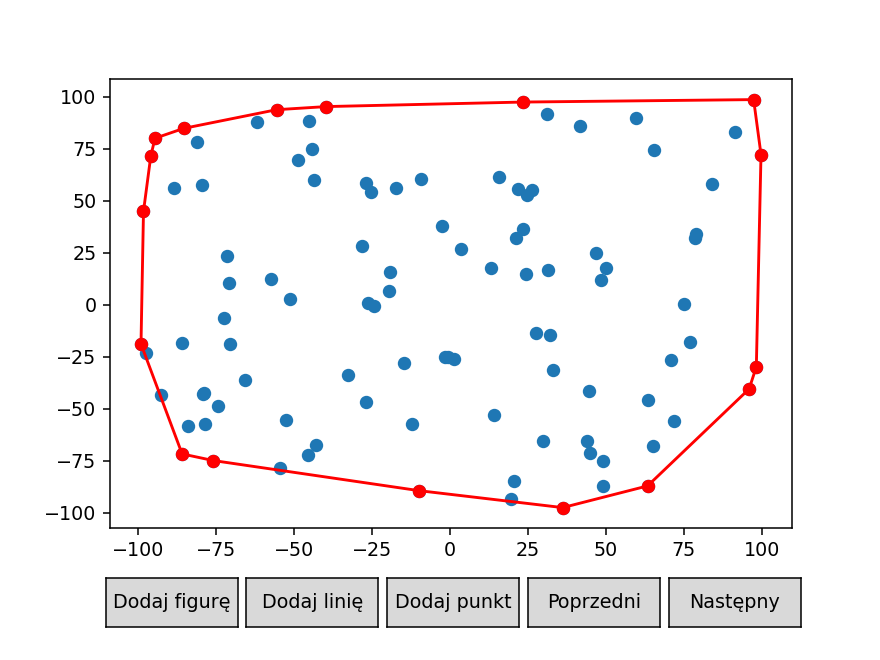

In [22]:
Ga = Graham(points_a)
plot = Plot(scenes=Ga[1])
plot.draw()

### zbiór wygenerowany dodatkowo

<IPython.core.display.Javascript object>


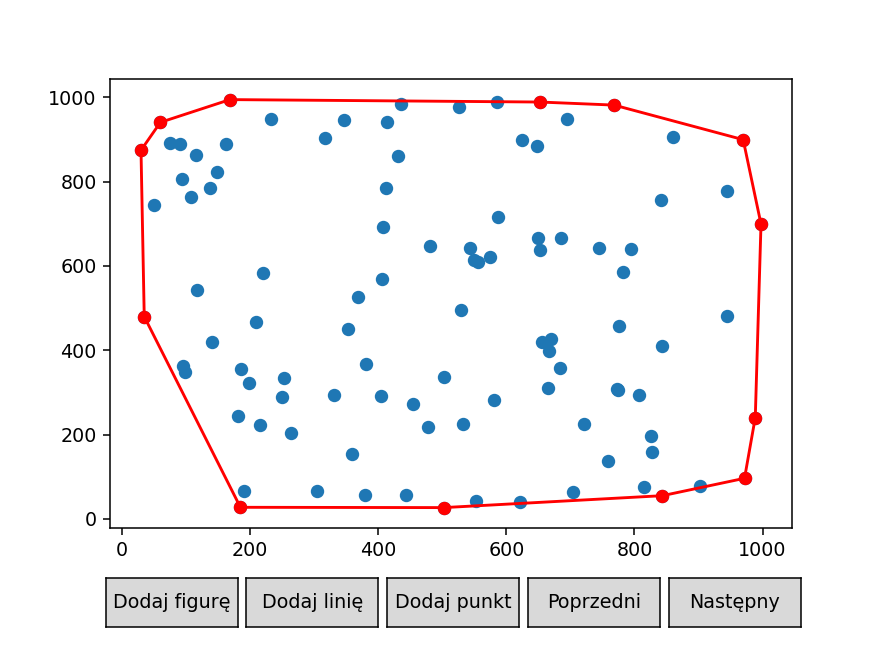

In [162]:
points_a2 = params_a(100, 10, 1000)
Ga2 = Graham(points_a2)
plot = Plot(scenes=Ga2[1])
plot.draw()

### Zbiór B

<IPython.core.display.Javascript object>


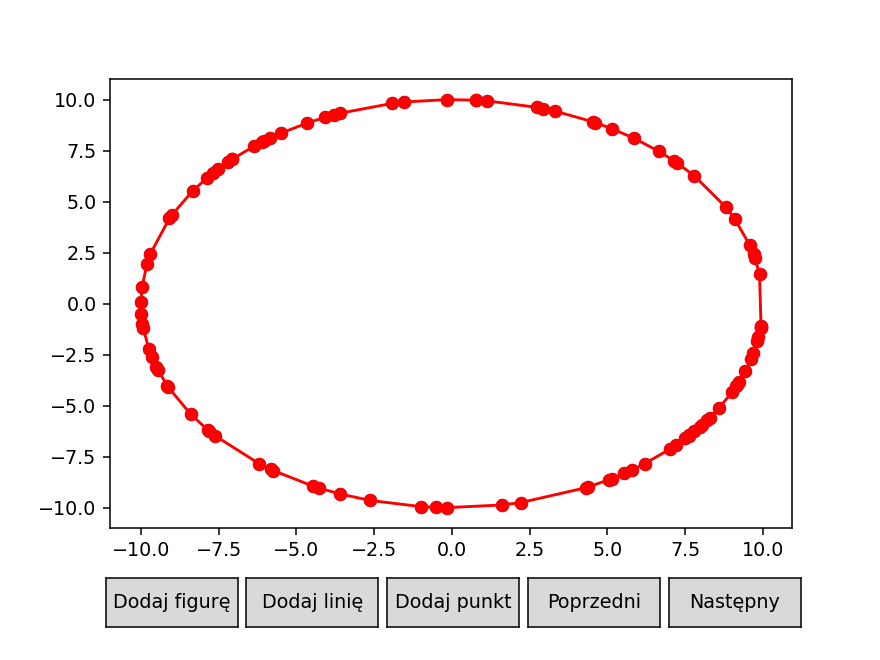

In [163]:
Gb = Graham(points_b)
plot = Plot(scenes=Gb[1])
plot.draw()

### zbiór wygenerowany dodatkowo

<IPython.core.display.Javascript object>


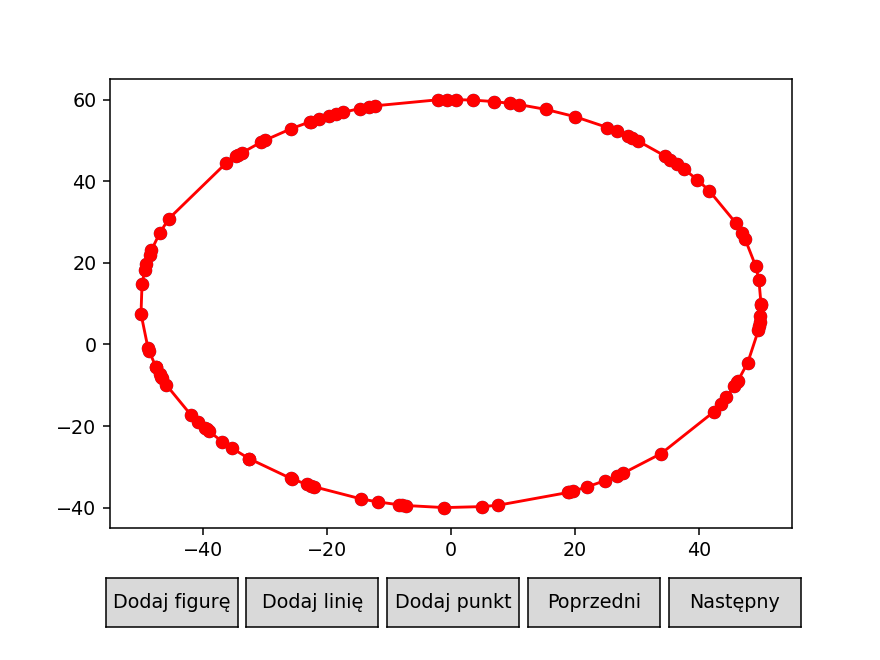

In [164]:
points_b2 = params_b(100, 0, 10, 50)
Gb2 = Graham(points_b2)
plot = Plot(scenes=Gb2[1])
plot.draw()

### Zbiór C

<IPython.core.display.Javascript object>


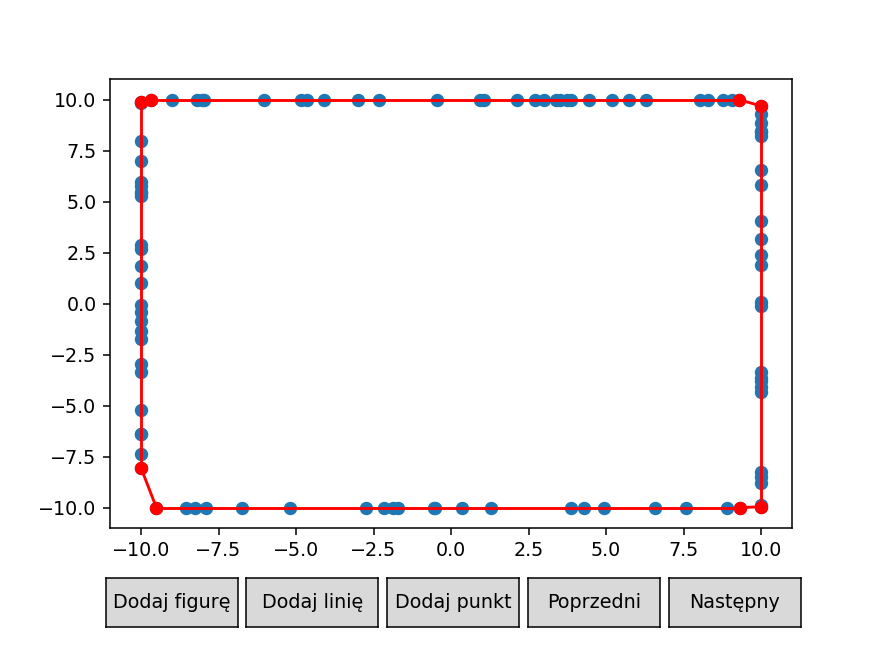

In [165]:
Gc = Graham(points_c)
plot = Plot(scenes=Gc[1])
plot.draw()

### Zbiór wygenerowany dodatkowo

<IPython.core.display.Javascript object>


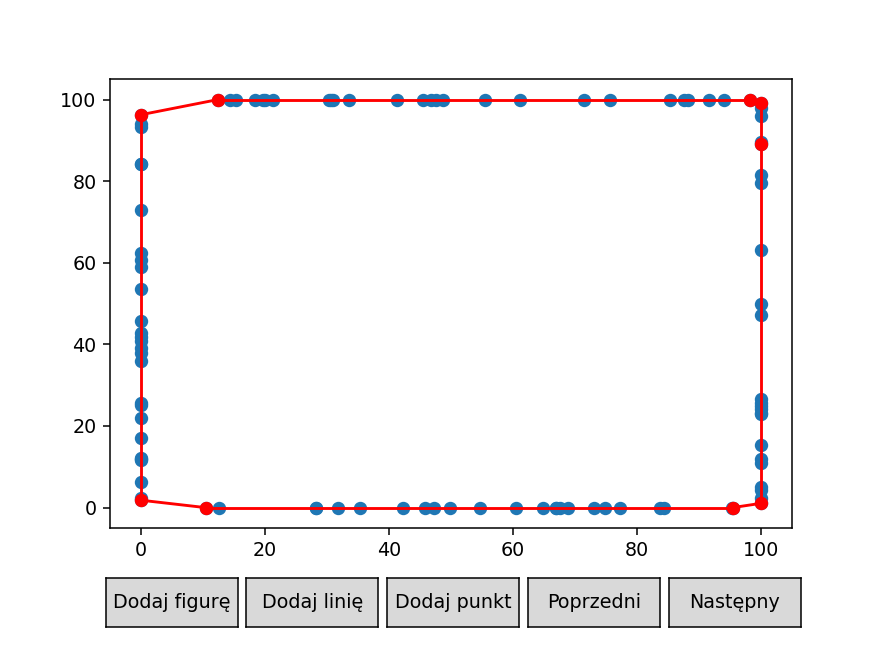

In [166]:
points_c2 = params_c(100, [[0,0],[100,0], [0,50], [100,50]])
Gc2 = Graham(points_c2)
plot = Plot(scenes=Gc2[1])
plot.draw()

### Zbiór D

<IPython.core.display.Javascript object>


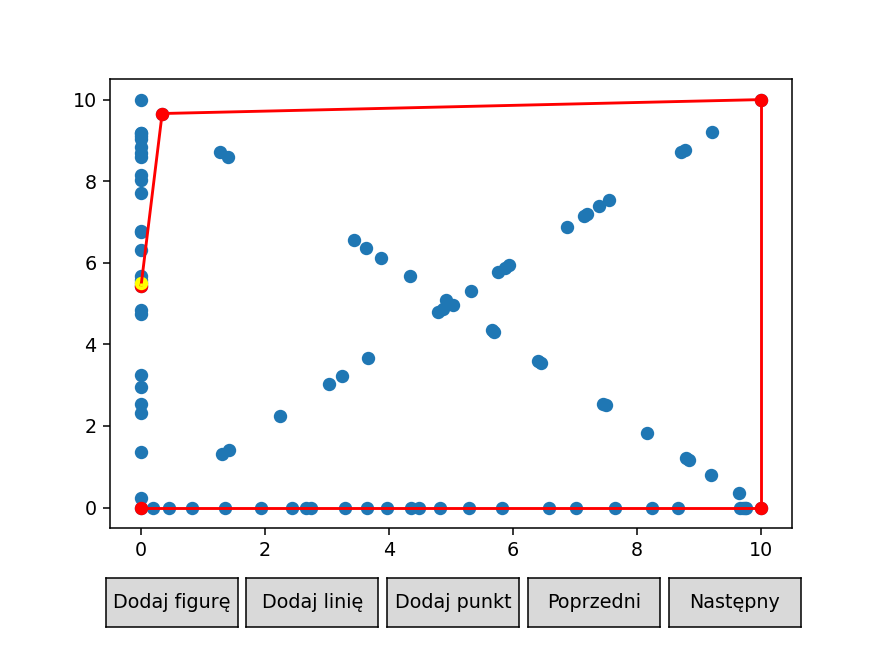

In [23]:
Gd = Graham(points_d)
plot = Plot(scenes=Gd[1])
plot.draw()

### Zbiór wygenerowany dodatkowo

<IPython.core.display.Javascript object>


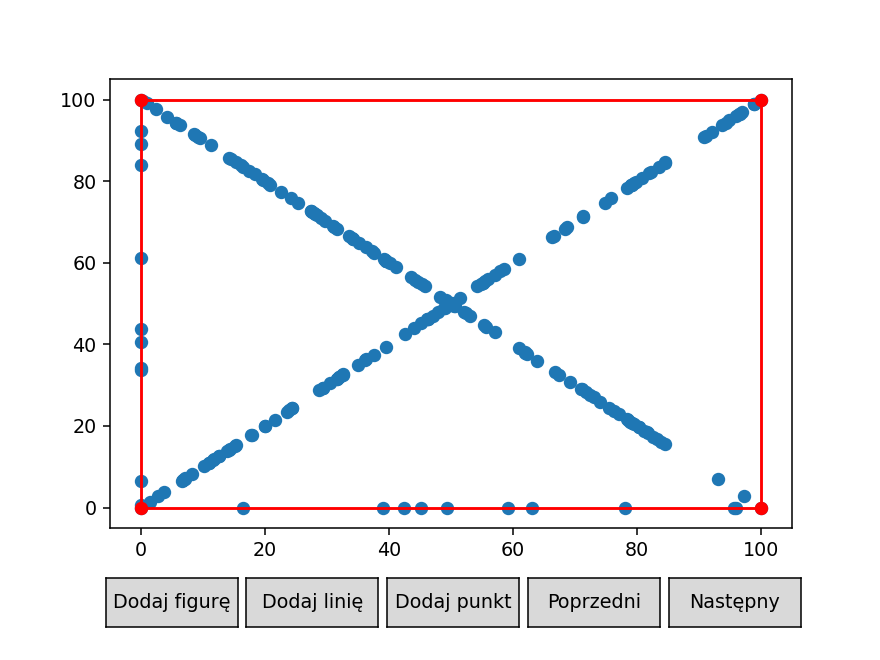

In [169]:
points_d2 = params_d([[0,0],[100,0], [0,100], [100,100]], 10, 100)
Gd2 = Graham(points_d2)
plot = Plot(scenes=Gd2[1])
plot.draw()

### DLA ALGORYTMU JARVISA

### Zbiór A

<IPython.core.display.Javascript object>


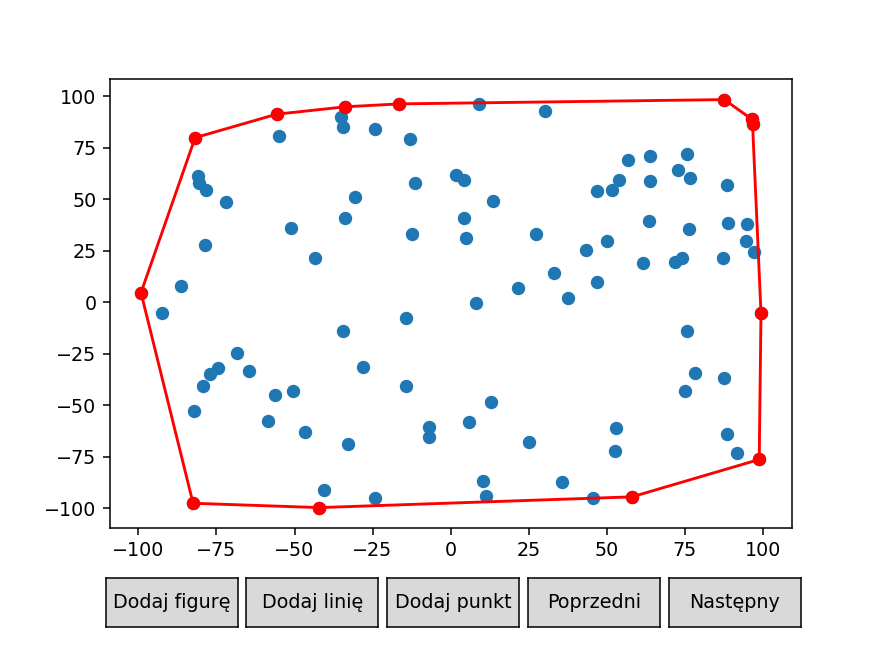

In [170]:
Ja = Jarvis(points_a)
plot = Plot(scenes=Ja[1])
plot.draw()

### Zbiór wygenerowany dodatkowo

<IPython.core.display.Javascript object>


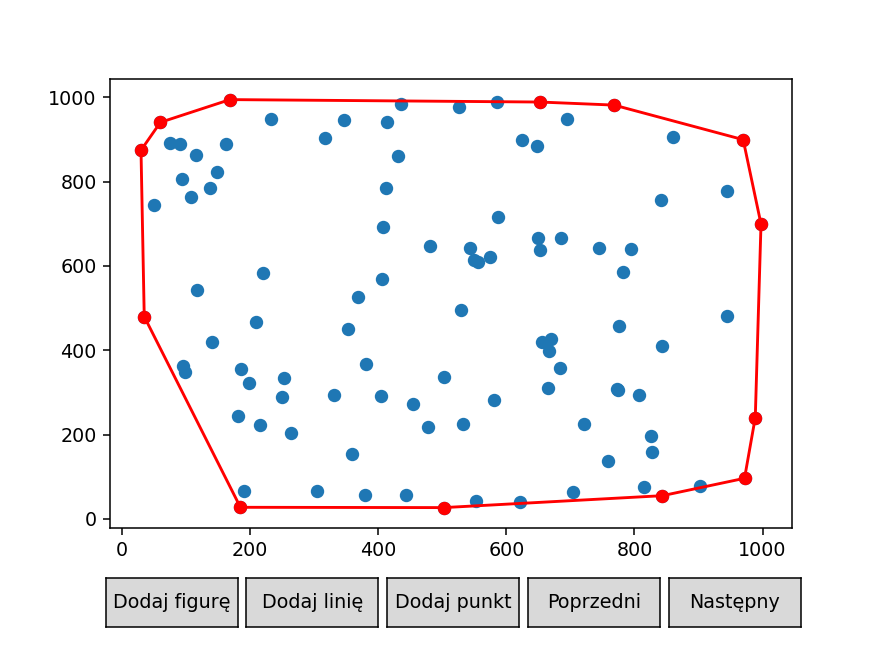

In [171]:
Ja2 = Jarvis(points_a2)
plot = Plot(scenes=Ja2[1])
plot.draw()

### Zbiór B

<IPython.core.display.Javascript object>


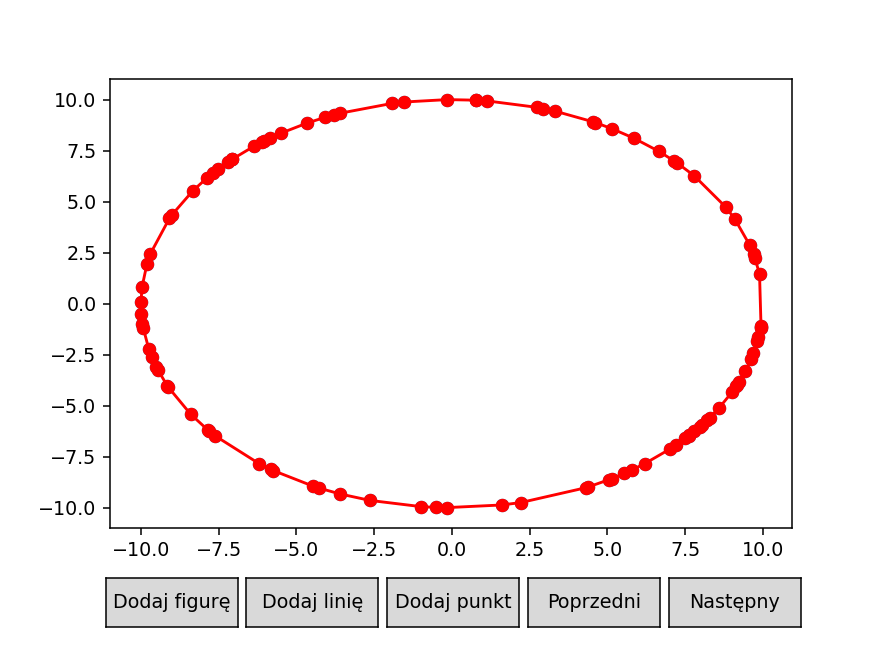

In [172]:
Jb = Jarvis(points_b)
plot = Plot(scenes=Jb[1])
plot.draw()

### Zbiór wygenerowany dodatkowo

<IPython.core.display.Javascript object>


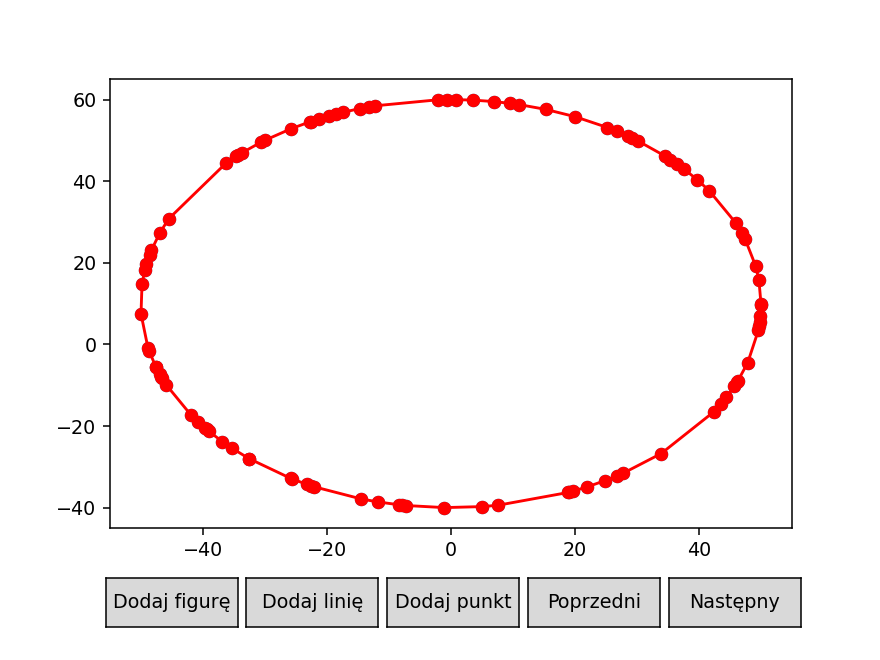

In [173]:
Jb2 = Jarvis(points_b2)
plot = Plot(scenes=Jb2[1])
plot.draw()

### Zbiór C

<IPython.core.display.Javascript object>


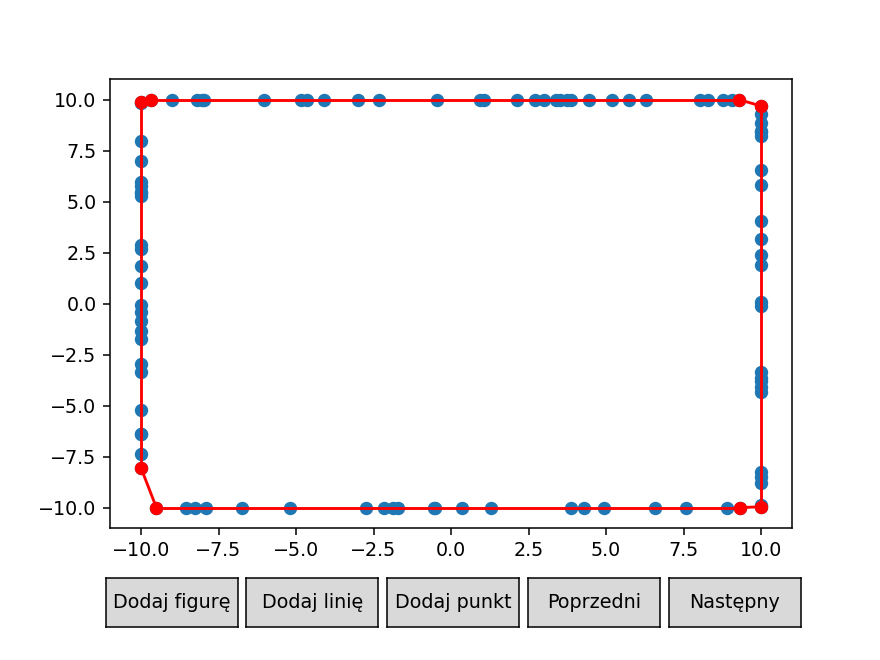

In [174]:
Jc = Jarvis(points_c)
plot = Plot(scenes=Jc[1])
plot.draw()

### Zbiór wygenerowany dodatkowo

<IPython.core.display.Javascript object>


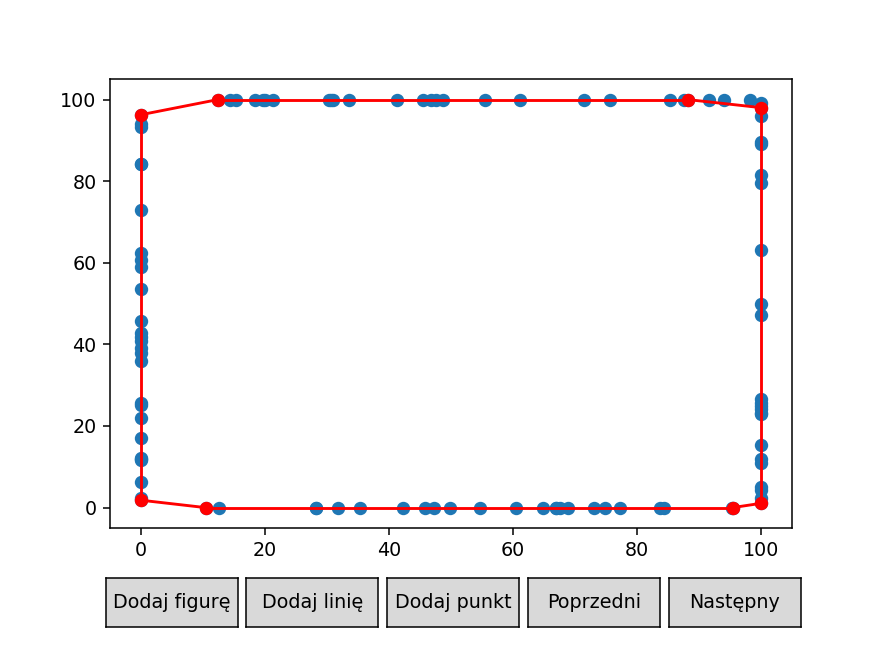

In [175]:
Jc2 = Jarvis(points_c2)
plot = Plot(scenes=Jc2[1])
plot.draw()

### Zbiór D

<IPython.core.display.Javascript object>


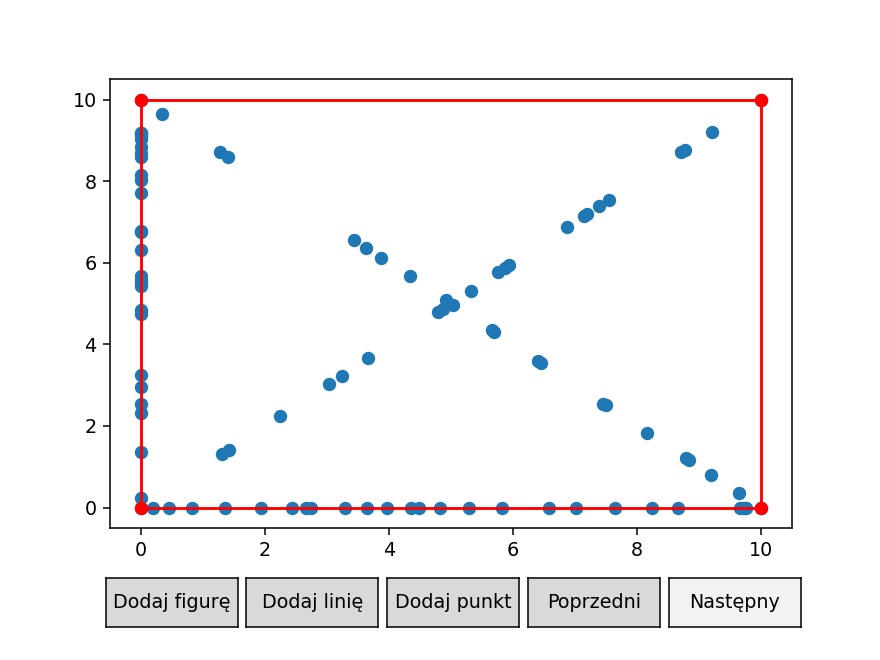

In [24]:
Jd = Jarvis(points_d)
plot = Plot(scenes=Jd[1])
plot.draw()

### Zbiór wygenerowany dodatkowo

<IPython.core.display.Javascript object>


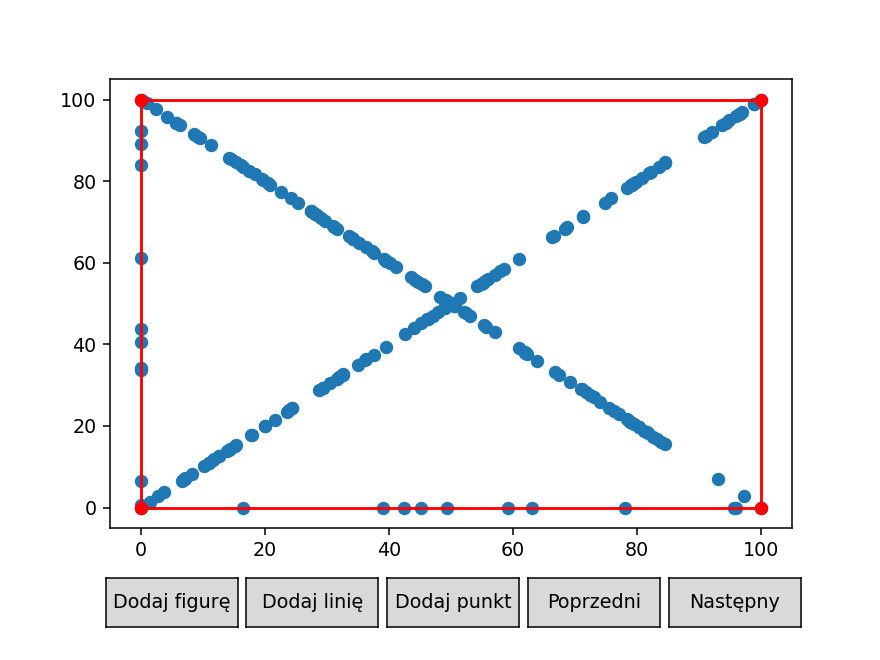

In [177]:
Jd2 = Jarvis(points_d2)
plot = Plot(scenes=Jd2[1])
plot.draw()

### Możliwość zapisu do pliku ciągu wierzchołków otoczki

In [178]:
def save_to_file(points):
    J_points = Jarvis(points)[0]
    G_points = Graham(points)[0]

    with open('jarvis.txt', 'w') as file:
        file.write("\n".join(str(point) for point in J_points))
    with open('graham.txt', 'w') as file:
        file.write("\n".join(str(point) for point in G_points))

### Sprawdzenie czasu działania algorytmu "z flagą"

In [29]:
import time
# name - name of the comparition to show
# digits - number of digits to round time to
# algoriths: 0 -> use both algoriths 
#            1 -> use only Jarvis
#            2 -> use only Graham
def timeCompare(name, points, algorithms=0, digits=4):
    print(name,"---------------------------------------")
    if algorithms == 0 or algorithms == 2:
        G_start = time.time()
        Graham(points, show=False)
        G_end = time.time()
        print("\t| Graham | %s\tsekund |" % round(G_end - G_start,digits))
    if algorithms == 0 or algorithms == 1:
        J_start = time.time()
        Jarvis(points, show=False)
        J_end = time.time()
        print("\t| Jarvis | %s\tsekund |" % round(J_end - J_start, digits))

### Sprawdzenie czasu działania algorytmu "bez flagi"

In [46]:
import time
# name - name of the comparition to show
# digits - number of digits to round time to
# algoriths: 0 -> use both algoriths 
#            1 -> use only Jarvis
#            2 -> use only Graham
def timeCompare_no_flag(name, points, algorithms=0, digits=4):
    print(name,"---------------------------------------")
    if algorithms == 0 or algorithms == 2:
        G_start = time.time()
        Graham_no_drawing(points)
        G_end = time.time()
        print("\t| Graham | %s\tsekund |" % round(G_end - G_start,digits))
    if algorithms == 0 or algorithms == 1:
        J_start = time.time()
        Jarvis_no_drawing(points)
        J_end = time.time()
        print("\t| Jarvis | %s\tsekund |" % round(J_end - J_start, digits))

In [180]:
timeCompare("Zestaw a", points_a)
timeCompare("Zestaw b", points_b)
timeCompare("Zestaw c", points_c)
timeCompare("Zestaw d", points_d)

Zestaw a ---------------------------------------
	| Graham | 0.01	sekund |
	| Jarvis | 0.017	sekund |
Zestaw b ---------------------------------------
	| Graham | 0.0091	sekund |
	| Jarvis | 0.0745	sekund |
Zestaw c ---------------------------------------
	| Graham | 0.007	sekund |
	| Jarvis | 0.012	sekund |
Zestaw d ---------------------------------------
	| Graham | 0.01	sekund |
	| Jarvis | 0.006	sekund |


In [42]:
set_a_100 = params_a(100, 0, 1000)
set_a_1000 = params_a(1000, 0, 1000)
set_a_2500 = params_a(2500, 0, 1000)
set_a_5000 = params_a(5000, 0, 1000)
set_a_10000 = params_a(10000, 0, 1000)
set_a_20000 = params_a(20000, 0, 1000)
set_a_100000 = params_a(100000, 0, 1000)

In [44]:
print("Zestaw A, z różnymi liczbami punktów, z flaga:")
timeCompare("100 punktów", set_a_100)
timeCompare("1000 punktów", set_a_1000)
timeCompare("2500 punktów", set_a_2500)
timeCompare("5000 punktów", set_a_5000)
timeCompare("10000 punktów", set_a_10000)
timeCompare("20000 punktów", set_a_20000)
# timeCompare("100000 punktów", set_a_100000)

Zestaw A, z różnymi liczbami punktów, z flaga:
100 punktów ---------------------------------------
	| Graham | 0.028	sekund |
	| Jarvis | 0.0442	sekund |
1000 punktów ---------------------------------------
	| Graham | 0.4519	sekund |
	| Jarvis | 0.6256	sekund |
2500 punktów ---------------------------------------
	| Graham | 0.8228	sekund |
	| Jarvis | 1.3049	sekund |
5000 punktów ---------------------------------------
	| Graham | 1.5884	sekund |
	| Jarvis | 2.993	sekund |
10000 punktów ---------------------------------------
	| Graham | 2.3723	sekund |
	| Jarvis | 4.1062	sekund |
20000 punktów ---------------------------------------
	| Graham | 5.634	sekund |
	| Jarvis | 10.1015	sekund |


In [47]:
print("Zestaw A, różnymi liczbami punktów, bez flagi:")
timeCompare_no_flag("100 punktów", set_a_100)
timeCompare_no_flag("1000 punktów", set_a_1000)
timeCompare_no_flag("2500 punktów", set_a_2500)
timeCompare_no_flag("5000 punktów", set_a_5000)
timeCompare_no_flag("10000 punktów", set_a_10000)
timeCompare_no_flag("20000 punktów", set_a_20000)
# timeCompare_no_flag("100000 punktów", set_a_100000)

Zestaw A, różnymi liczbami punktów, bez flagi:
100 punktów ---------------------------------------
	| Graham | 0.0186	sekund |
	| Jarvis | 0.0282	sekund |
1000 punktów ---------------------------------------
	| Graham | 0.2559	sekund |
	| Jarvis | 0.4881	sekund |
2500 punktów ---------------------------------------
	| Graham | 0.8842	sekund |
	| Jarvis | 1.4489	sekund |
5000 punktów ---------------------------------------
	| Graham | 1.5661	sekund |
	| Jarvis | 3.0733	sekund |
10000 punktów ---------------------------------------
	| Graham | 2.6407	sekund |
	| Jarvis | 4.5661	sekund |
20000 punktów ---------------------------------------
	| Graham | 5.1652	sekund |
	| Jarvis | 8.6242	sekund |


In [195]:
set_b_100 = params_b(100, 0, 0, 1000)
set_b_1000 = params_b(1000, 0, 0, 1000)
set_b_2500 = params_b(2500, 0, 0, 1000)
set_b_5000 = params_b(5000, 0, 0, 1000)
set_b_10000 = params_b(10000, 0, 0, 1000)
set_b_20000 = params_b(20000, 0, 0, 1000)
set_b_100000 = params_b(100000, 0, 0, 1000)

In [196]:
print("Zestaw B, Jarvis:")
timeCompare("100 punktów", set_b_100, 2)
timeCompare("1000 punktów", set_b_1000, 2)
timeCompare("2500 punktów", set_b_2500, 2)
timeCompare("5000 punktów", set_b_5000, 2)
timeCompare("10000 punktów", set_b_10000, 2)
timeCompare("20000 punktów", set_b_20000, 2)
timeCompare("100000 punktów", set_b_100000, 2)

Zestaw B, Jarvis:
100 punktów ---------------------------------------
	| Graham | 0.008	sekund |
1000 punktów ---------------------------------------
	| Graham | 0.1311	sekund |
2500 punktów ---------------------------------------
	| Graham | 0.3921	sekund |
5000 punktów ---------------------------------------
	| Graham | 0.8402	sekund |
10000 punktów ---------------------------------------
	| Graham | 1.7243	sekund |
20000 punktów ---------------------------------------
	| Graham | 3.7462	sekund |
100000 punktów ---------------------------------------
	| Graham | 21.8598	sekund |


In [184]:
print("Zestaw B, różnymi liczbami punktów:")
timeCompare("100 punktów", set_b_100)
timeCompare("1000 punktów", set_b_1000)
timeCompare("2500 punktów", set_b_2500)
timeCompare("5000 punktów", set_b_5000)
timeCompare("10000 punktów", set_b_10000)
timeCompare("20000 punktów", set_b_20000)

Zestaw B, różnymi liczbami punktów:
100 punktów ---------------------------------------
	| Graham | 0.01	sekund |
	| Jarvis | 0.0741	sekund |
1000 punktów ---------------------------------------
	| Graham | 0.128	sekund |
	| Jarvis | 9.5319	sekund |
2500 punktów ---------------------------------------
	| Graham | 0.4101	sekund |


KeyboardInterrupt: 

In [48]:
vertices = [[0,0], [0,100], [50,0], [50,100]]
set_c_100 = params_c(100, vertices)
set_c_1000 = params_c(1000, vertices)
set_c_2500 = params_c(2500, vertices)
set_c_5000 = params_c(5000, vertices)
set_c_10000 = params_c(10000, vertices)
set_c_20000 = params_c(20000, vertices)
set_c_100000 = params_c(100000, vertices)

In [49]:
print("Zestaw C, różnymi liczbami punktów z flagą:")
timeCompare("100 punktów", set_c_100)
timeCompare("1000 punktów", set_c_1000)
timeCompare("2500 punktów", set_c_2500)
timeCompare("5000 punktów", set_c_5000)
timeCompare("10000 punktów", set_c_10000)
timeCompare("20000 punktów", set_c_20000)
# timeCompare("100000 punktów", set_c_100000)

Zestaw C, różnymi liczbami punktów:
100 punktów ---------------------------------------
	| Graham | 0.016	sekund |
	| Jarvis | 0.016	sekund |
1000 punktów ---------------------------------------
	| Graham | 0.3111	sekund |
	| Jarvis | 0.168	sekund |
2500 punktów ---------------------------------------
	| Graham | 1.0431	sekund |
	| Jarvis | 0.4601	sekund |
5000 punktów ---------------------------------------
	| Graham | 2.0969	sekund |
	| Jarvis | 0.7962	sekund |
10000 punktów ---------------------------------------
	| Graham | 4.089	sekund |
	| Jarvis | 1.4324	sekund |
20000 punktów ---------------------------------------
	| Graham | 4.9074	sekund |
	| Jarvis | 1.9455	sekund |


In [51]:
print("Zestaw C, różnymi liczbami punktów bez flagi:")
timeCompare_no_flag("100 punktów", set_c_100)
timeCompare_no_flag("1000 punktów", set_c_1000)
timeCompare_no_flag("2500 punktów", set_c_2500)
timeCompare_no_flag("5000 punktów", set_c_5000)
timeCompare_no_flag("10000 punktów", set_c_10000)
timeCompare_no_flag("20000 punktów", set_c_20000)

Zestaw C, różnymi liczbami punktów bez flagi:
100 punktów ---------------------------------------
	| Graham | 0.0154	sekund |
	| Jarvis | 0.016	sekund |
1000 punktów ---------------------------------------
	| Graham | 0.2841	sekund |
	| Jarvis | 0.172	sekund |
2500 punktów ---------------------------------------
	| Graham | 0.8162	sekund |
	| Jarvis | 0.3961	sekund |
5000 punktów ---------------------------------------
	| Graham | 1.7946	sekund |
	| Jarvis | 0.7842	sekund |
10000 punktów ---------------------------------------
	| Graham | 3.4933	sekund |
	| Jarvis | 1.4996	sekund |
20000 punktów ---------------------------------------
	| Graham | 5.4854	sekund |
	| Jarvis | 1.8925	sekund |


In [52]:
vertices = [[0,0], [0,100], [100,0], [100,100]]
set_d_100 = params_d(vertices, 25, 25)
set_d_1000 = params_d(vertices, 250, 250)
set_d_2500 = params_d(vertices, 625, 625)
set_d_5000 = params_d(vertices, 1250, 1250)
set_d_10000 = params_d(vertices, 2500, 2500)
set_d_20000 = params_d(vertices, 5000, 5000)
set_d_100000 = params_d(vertices, 25000, 25000)

In [53]:
print("Zestaw D, różnymi liczbami punktów:")
timeCompare("100 punktów", set_d_100)
timeCompare("1000 punktów", set_d_1000)
timeCompare("2500 punktów", set_d_2500)
timeCompare("5000 punktów", set_d_5000)
timeCompare("10000 punktów", set_d_10000)
timeCompare("20000 punktów", set_d_20000)
# timeCompare("100000 punktów", set_d_100000)

Zestaw D, różnymi liczbami punktów:
100 punktów ---------------------------------------
	| Graham | 0.0202	sekund |
	| Jarvis | 0.012	sekund |
1000 punktów ---------------------------------------
	| Graham | 0.3086	sekund |
	| Jarvis | 0.108	sekund |
2500 punktów ---------------------------------------
	| Graham | 1.0367	sekund |
	| Jarvis | 0.3361	sekund |
5000 punktów ---------------------------------------
	| Graham | 2.6451	sekund |
	| Jarvis | 0.6843	sekund |
10000 punktów ---------------------------------------
	| Graham | 4.9208	sekund |
	| Jarvis | 0.7642	sekund |
20000 punktów ---------------------------------------
	| Graham | 6.7322	sekund |
	| Jarvis | 1.2283	sekund |


In [55]:
print("Zestaw D, różnymi liczbami punktów:")
timeCompare_no_flag("100 punktów", set_d_100)
timeCompare_no_flag("1000 punktów", set_d_1000)
timeCompare_no_flag("2500 punktów", set_d_2500)
timeCompare_no_flag("5000 punktów", set_d_5000)
timeCompare_no_flag("10000 punktów", set_d_10000)
timeCompare_no_flag("20000 punktów", set_d_20000)

Zestaw D, różnymi liczbami punktów:
100 punktów ---------------------------------------
	| Graham | 0.0202	sekund |
	| Jarvis | 0.0118	sekund |
1000 punktów ---------------------------------------
	| Graham | 0.295	sekund |
	| Jarvis | 0.1	sekund |
2500 punktów ---------------------------------------
	| Graham | 0.9795	sekund |
	| Jarvis | 0.2561	sekund |
5000 punktów ---------------------------------------
	| Graham | 2.6904	sekund |
	| Jarvis | 0.6327	sekund |
10000 punktów ---------------------------------------
	| Graham | 4.7144	sekund |
	| Jarvis | 0.8402	sekund |
20000 punktów ---------------------------------------
	| Graham | 5.784	sekund |
	| Jarvis | 1.3048	sekund |
